<a href="https://colab.research.google.com/github/ArtemPavlovich/HSE_AML_course/blob/master/Bayesian_Methods/week6/Copy_of_gp_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First things first
Click **File -> Save a copy in Drive** and click **Open in new tab** in the pop-up window to save your progress in Google Drive.

# Gaussian processes and Bayesian optimization

In this assignment you will learn how to use <a href="http://sheffieldml.github.io/GPy/">GPy</a> and <a href="http://sheffieldml.github.io/GPyOpt/">GPyOpt</a> libraries to deal with gaussian processes. These libraries provide quite simple and inuitive interfaces for training and inference, and we will try to get familiar with them in a few tasks.

### Setup
Load auxiliary files and then install and import the necessary libraries.

In [0]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Downloading Colab files")
    ! shred -u setup_google_colab.py
    ! wget https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.load_data_week6()

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2020-03-03 15:04:58--  https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1254 (1.2K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.22K  --.-KB/s    in 0s      

2020-03-03 15:04:58 (251 MB/s) - ‘setup_google_colab.py’ saved [1254/1254]

https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/week6/w6_grader.py w6_grader.py


In [0]:
! pip install GPy gpyopt xgboost

     |████████████████████████████████| 1.0MB 5.1MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633987 sha256=4a17da1970677f5d5173aad65d7169be649b6b3c9c6a8b4a524c9e646b228ba5
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for gpyopt: filename=GPyOpt-1.2.5-cp36-none-any.whl size=83027 sha256=ccb2e8420c884df6418c82cf38ee540a96e2d18ffd7f9ad16bbdb7ea0e5e0f03
  Stored in directory: /root/.cache/pip/wheels/33/1d/87/dc02440831ba986b1547dd11a7dcd44e893b0527083066d869
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102552 sha256=d4305ca86f0e217ccf760f1ebe472477d8c1e1182048d707359c7f7c69f7ffc9
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy gpyopt paramz


In [0]:
import numpy as np
import GPy
import GPyOpt
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import sklearn.datasets
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import time
from w6_grader import GPGrader
%matplotlib inline

ModuleNotFoundError: ignored

### Grading
We will create a grader instace below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to platform only after running submiting function in the last part of this assignment. If you want to make partial submission, you can run that cell any time you want.

In [0]:
grader = GPGrader()

## Gaussian processes: GPy (<a href="http://pythonhosted.org/GPy/">documentation</a>)

We will start with a simple regression problem, for which we will try to fit a Gaussian Process with RBF kernel.

In [0]:
def generate_points(n=25, noise_variance=0.0036):
    np.random.seed(777)
    X = np.random.uniform(-3., 3., (n, 1))
    y = np.sin(X) + np.random.randn(n, 1) * noise_variance**0.5
    return X, y
    
def generate_noise(n=25, noise_variance=0.0036):
    np.random.seed(777)
    X = np.random.uniform(-3., 3., (n, 1))
    y = np.random.randn(n, 1) * noise_variance**0.5
    return X, y

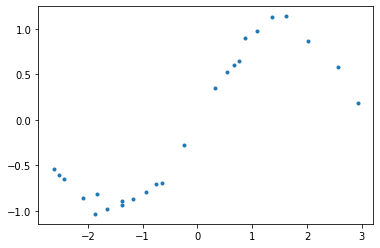

[[-2.08401759]
 [-1.18586034]
 [-2.62778151]
 [-0.24083795]
 [ 2.01152031]
 [ 2.56198229]
 [ 1.36193391]
 [ 1.61097733]
 [-1.3847696 ]
 [ 0.86417575]
 [-2.43976046]
 [-2.52188469]
 [ 0.53768252]
 [-0.93995677]
 [ 2.93325689]
 [ 0.75883924]
 [ 1.09067568]
 [ 0.31354088]
 [-1.38683965]
 [-0.76044368]
 [-1.66243141]
 [-1.8813444 ]
 [-0.65611144]
 [-1.84102557]
 [ 0.66546559]]


In [0]:
# Create data points
X, y = generate_points()
plt.plot(X, y, '.')
plt.show()
print(X)

To fit a Gaussian Process, you will need to define a kernel. For Gaussian (GBF) kernel you can use `GPy.kern.RBF` function.

<b> Task 1.1: </b> Create RBF kernel with variance 1.5 and length-scale parameter 2 for 1D samples and compute value of the kernel between points `X[5]` and `X[9]`. Submit a single number. 
<br><b>Hint:</b> use `.K` property of kernel object.

In [0]:
kernel = GPy.kern.src.rbf.RBF(1,variance=1.5, lengthscale=2.) ### YOUR CODE HERE
kernel_59 = kernel.K(X[9:10], X[5:6]) ### YOUR CODE HERE
grader.submit_GPy_1(kernel_59)

Current answer for task 1.1 is: 1.0461813545396959


<b> Task 1.2: </b> Fit GP into generated data. Use kernel from previous task. Submit predicted mean and vairance at position $x=1$.
<br><b>Hint:</b> use `GPy.models.GPRegression` class.

In [0]:
model = GPy.models.gp_regression.GPRegression(X, y, kernel=kernel) ### YOUR CODE HERE
mean = model.predict(np.array([[1.]]))[0] ### YOUR CODE HERE
variance = model.predict(np.array([[1.]]))[1]### YOUR CODE HERE
grader.submit_GPy_2(mean, variance)

Current answer for task 1.2 (mean) is: 0.6646774926102937
Current answer for task 1.2 (variance) is: 1.1001478223790582


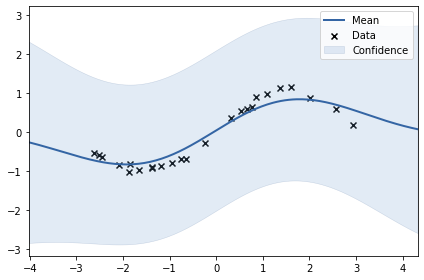

In [0]:
model.plot()
plt.show()

We see that the model didn't fit the data quite well. Let's try to fit kernel and noise parameters automatically as discussed in the lecture! You can see the current parameters below:

In [0]:
model.optimize()

<b> Task 1.3: </b> Optimize length-scale, variance and noise component of the model and submit optimal length-scale value of the kernel. 
<br><b>Hint:</b> Use `.optimize()` function of the model and `.lengthscale` property of the kernel.

In [0]:
lengthscale = kernel.lengthscale### YOUR CODE HERE
grader.submit_GPy_3(lengthscale)

Current answer for task 1.3 is: 1.6252681650349912


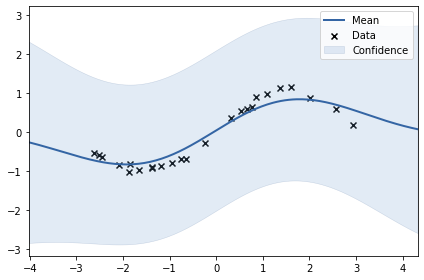

In [0]:
model.plot()
plt.show()

As you see, the process generates outputs just right. Let's see if GP can figure out itself when we try to fit it into noise or signal.

<b> Task 1.4: </b> Generate two datasets: sinusoid wihout noise and samples from gaussian noise. Optimize kernel parameters and submit optimal values of noise component.
<br><b>Note:</b> generate data only using ```generate_points(n, noise_variance)``` and ```generate_noise(n, noise_variance)``` function!

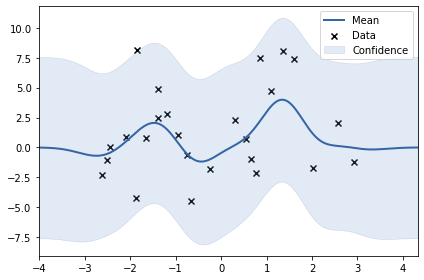

In [0]:
X, y = generate_noise(noise_variance=10)
### YOUR CODE HERE
kernel_noise = GPy.kern.src.rbf.RBF(1,variance=1.5, lengthscale=2.)
model_noise = GPy.models.gp_regression.GPRegression(X, y, kernel=kernel_noise)
model_noise.optimize()
noise = model_noise.predict(X[9:10])[1]
model_noise.plot()
plt.show()

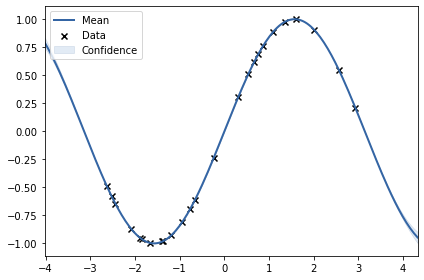

In [0]:
X, y = generate_points(noise_variance=0)
### YOUR CODE HERE
kernel_signal = GPy.kern.src.rbf.RBF(1,variance=1.5, lengthscale=2.)
model_signal = GPy.models.gp_regression.GPRegression(X, y, kernel=kernel_signal)
model_signal.optimize()
just_signal = model_signal.predict(X[9:10])[1]
model_signal.plot()
plt.show()

In [0]:
grader.submit_GPy_4(noise, just_signal)

Current answer for task 1.4 (noise) is: 11.73071948612898
Current answer for task 1.4 (just signal) is: 2.0287435390508018e-09


## Sparse GP
Now let's consider the speed of GP. We will generate a dataset of 3000 points and measure the time that is consumed for prediction of mean and variance for each point. We will then try to use inducing inputs and find the optimal number of points according to quality-time tradeoff.

For the sparse model with inducing points, you should use ```GPy.models.SparseGPRegression``` class. You can set the number of inducing inputs with parameter ```num_inducing``` and optimize their positions and values with ```.optimize()``` call.

<b>Task 1.5</b>: Create a dataset of 1000 points and fit GPRegression. Measure time for predicting mean and variance at position $x=1$. Then fit `SparseGPRegression` with 10 inducing inputs and repeat the experiment. Report speedup as a ratio between consumed time without and with inducing inputs.

In [0]:
X, y = generate_points(1000)

In [0]:
start = time.time()
### YOUR CODE HERE
mean = model.predict(np.array([[1.]]))[0] ### YOUR CODE HERE
variance = model.predict(np.array([[1.]]))[1]### YOUR CODE HERE
time_gp = time.time()-start

In [0]:
model_sparse = GPy.models.sparse_gp_regression.SparseGPRegression(X, y, kernel=kernel)
start = time.time()
### YOUR CODE HERE
mean = model_sparse.predict(np.array([[1.]]))[0] ### YOUR CODE HERE
variance = model_sparse.predict(np.array([[1.]]))[1]### YOUR CODE HERE
time_sgp = time.time()-start

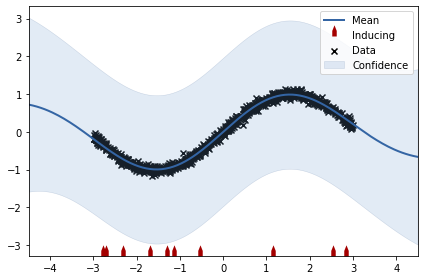

In [0]:
model_sparse.plot()
plt.show()

In [0]:
grader.submit_GPy_5(time_gp / time_sgp)

Current answer for task 1.5 is: 2.8461538461538463


## Bayesian optimization: GPyOpt (<a href="http://pythonhosted.org/GPyOpt/">documentation</a>, <a href="http://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/index.ipynb">tutorials</a>)

In this part of the assignment, we will try to find optimal hyperparameters to XGBoost model! We will use data from a small competition to speed things up, but keep in mind that the approach works even for large datasets.

We will use diabetes dataset provided in sklearn package.

In [0]:
dataset = sklearn.datasets.load_diabetes()
X = dataset['data']
y = dataset['target']

We will use cross-validation score to estimate accuracy and our goal will be to tune: ```max_depth```, ```learning_rate```, ```n_estimators``` parameters. The baseline MSE with default XGBoost parameters is $0.2$. Let's see if we can do better. First, we have to define optimization function and domains.

In [0]:
# Score. Optimizer will try to find minimum, so we will add a "-" sign.
def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
        XGBRegressor(learning_rate=parameters[0],
                     max_depth=int(parameters[2]),
                     n_estimators=int(parameters[3]),
                     gamma=int(parameters[1]),
                     min_child_weight = parameters[4]), 
        X, y, scoring='neg_mean_squared_error'
    ).mean()
    score = np.array(score)
    return score

In [0]:
baseline = -cross_val_score(
    XGBRegressor(), X, y, scoring='neg_mean_squared_error'
).mean()
baseline

[18:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


3437.074407214106

In [0]:
# Bounds (NOTE: define continuous variables first, then discrete!)
bounds = [
    {'name': 'learning_rate',
     'type': 'continuous',
     'domain': (0, 1)},

    {'name': 'gamma',
     'type': 'continuous',
     'domain': (0, 5)},

    {'name': 'max_depth',
     'type': 'discrete',
     'domain': (1, 50)},

    {'name': 'n_estimators',
     'type': 'discrete',
     'domain': (1, 300)},

    {'name': 'min_child_weight',
     'type': 'discrete',
     'domain': (1, 10)}
]

In [0]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(
    f=f, domain=bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)

[18:32:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [0]:
max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)

[18:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

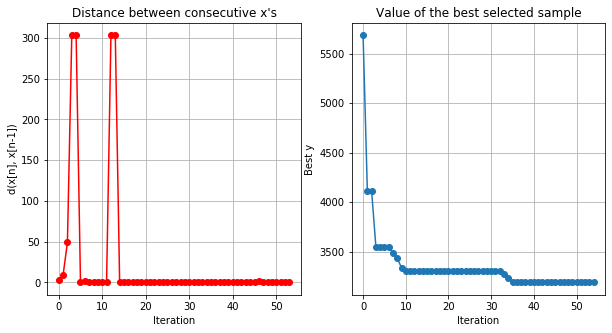

In [0]:
optimizer.plot_convergence()

Best values of parameters:

In [0]:
optimizer.X[np.argmin(optimizer.Y)]

array([4.76325090e-02, 1.19202751e+00, 1.00000000e+00, 3.00000000e+02,
       1.00000000e+00])

In [0]:
print('MSE:', np.min(optimizer.Y),
      'Gain:', (baseline-np.min(optimizer.Y))/np.min(optimizer.Y)*100)

MSE: 3189.185708011576 Gain: 7.7727897306139


We were able to get 9% boost without tuning parameters by hand! Let's see if you can do the same. 

<b>Task 2.1:</b> Tune SVR model. Find optimal values for three parameters: `C`, `epsilon` and `gamma`. Use range (1e-5, 1000) for `C`, (1e-5, 10) for `epsilon` and `gamma`. Use MPI as an acquisition function with weight 0.1. Submit the optimal value of epsilon that was found by a model.

In [0]:
### YOUR CODE HERE
def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
        SVR(C=parameters[0], epsilon=parameters[1],
        gamma=parameters[2]),
        X, y, scoring='neg_mean_squared_error'
    ).mean()
    score = np.array(score)
    return score

In [0]:
baseline = -cross_val_score(
    SVR(), X, y, scoring='neg_mean_squared_error'
).mean()
baseline

4976.655882526393

In [0]:
bounds = [
    {'name': 'C',
     'type': 'continuous',
     'domain': (1e-5, 1000)},

    {'name': 'epsilon',
     'type': 'continuous',
     'domain': (1e-5, 10)},

    {'name': 'gamma',
     'type': 'continuous',
     'domain': (1e-5, 10)}
]

In [0]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(
    f=f, domain=bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)

In [0]:
max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)

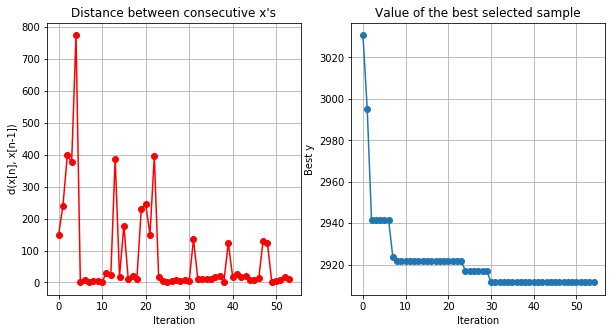

In [0]:
optimizer.plot_convergence()

In [0]:
optimizer.X[np.argmin(optimizer.Y)]

array([37.6645348, 10.       ,  8.8905192])

In [0]:
best_epsilon = optimizer.X[np.argmin(optimizer.Y)][1]### YOUR CODE HERE
grader.submit_GPyOpt_1(best_epsilon)

Current answer for task 2.1 is: 10.0


<b>Task 2.2:</b> For the model above submit boost in improvement that you got after tuning hyperparameters (output percents) [e.g. if baseline MSE was 40 and you got 20, output number 200]

In [0]:
np.min(optimizer.Y)

2911.470304239638

In [0]:
performance_boost = baseline / np.min(optimizer.Y) ### YOUR CODE HERE
grader.submit_GPyOpt_2(performance_boost*100)

Current answer for task 2.2 is: 170.9327371561875


# Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate a token on this programming assignment's page. <b>Note:</b> The token expires 30 minutes after generation.

In [0]:
STUDENT_EMAIL = 'kleinekrokodil@yandex.ru'# EMAIL HERE
STUDENT_TOKEN = 'J1gsvseuFc5O8LxZ' # TOKEN HERE
grader.status()

You want to submit these numbers:
Task 1.1: 1.0461813545396959
Task 1.2 (mean): 0.6646774926102937
Task 1.2 (variance): 1.1001478223790582
Task 1.3: 1.6252681650349912
Task 1.4 (noise): 11.73071948612898
Task 1.4 (just signal): 2.0287435390508018e-09
Task 1.5: 2.8461538461538463
Task 2.1: 10.0
Task 2.2: 170.9327371561875


If you want to submit these answers, run cell below

In [0]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
# psd_kernels = tfp.math.psd_kernels
# Suppose we have some data from a known function. Note the index points in
# general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one
# here).
f = lambda x: np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2)

observation_index_points = np.random.uniform(-1., 1., 50)[..., np.newaxis]
observations = f(observation_index_points) + np.random.normal(0., .05, 50)

# Define a kernel with trainable parameters. Note we transform the trainable
# variables to apply a positivity constraint.
amplitude = tf.exp(tf.Variable(np.float64(0)), name='amplitude')
length_scale = tf.exp(tf.Variable(np.float64(0)), name='length_scale')
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

observation_noise_variance = tf.exp(
    tf.Variable(np.float64(-5)), name='observation_noise_variance')

# We'll use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)
neg_log_likelihood = -gp.log_prob(observations)

optimizer = tf.train.AdamOptimizer(learning_rate=.05, beta1=.5, beta2=.99)
optimize = optimizer.minimize(neg_log_likelihood)

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the same parameters, which we'll optimize below).
index_points = np.linspace(-1., 1., 100)[..., np.newaxis]
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(10)
# ==> 10 independently drawn, joint samples at `index_points`.

# Now execute the above ops in a Session, first training the model
# parameters, then drawing and plotting posterior samples.
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for i in range(1000):
    _, neg_log_likelihood_ = sess.run([optimize, neg_log_likelihood])
    if i % 100 == 0:
      print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

  print("Final NLL = {}".format(neg_log_likelihood_))
  samples_ = sess.run(samples)

  plt.scatter(np.squeeze(observation_index_points), observations)
  plt.plot(np.stack([index_points[:, 0]]*10).T, samples_.T, c='r', alpha=.2)

AttributeError: ignored